
           Model Performance            
Model               MSE                 R^2 Score           
------------------------------------------------------------
Linear Regression   93.05               0.00                
Random Forest       15.48               0.83                



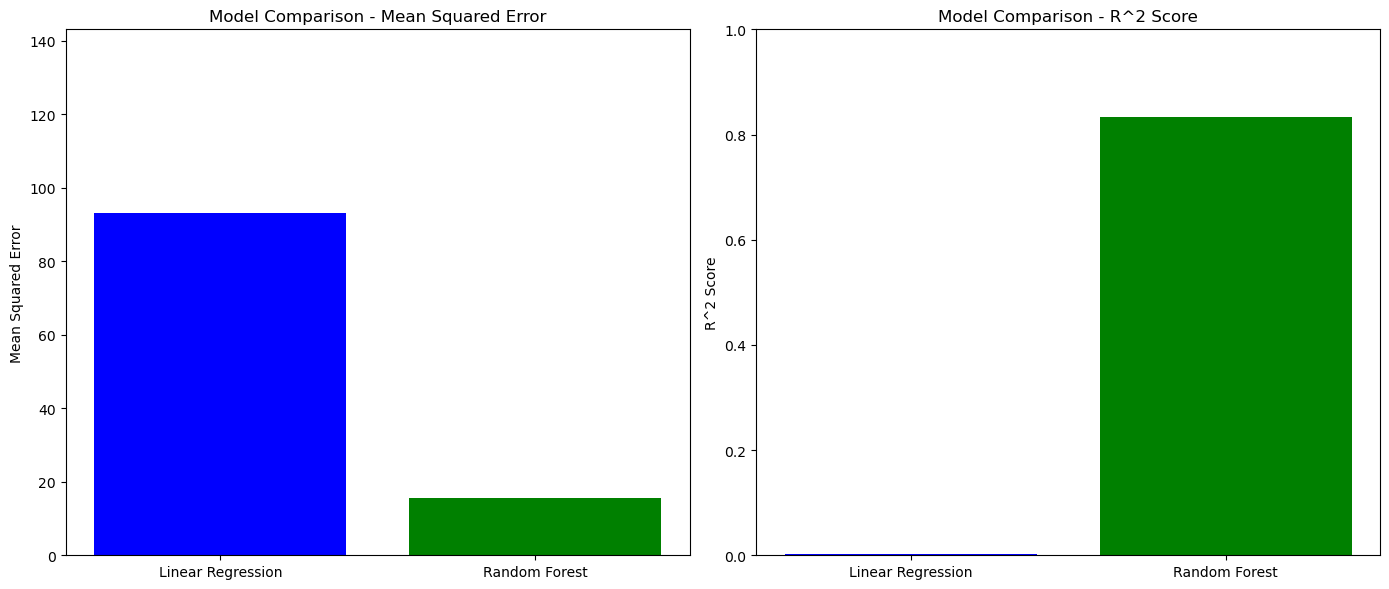

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from haversine import haversine

# Load the dataset
df = pd.read_csv('file:///Users/Avdhut/Downloads/uber.csv')

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'key'])

# Handle missing values by dropping rows with NaNs in critical columns
df = df.dropna(subset=['dropoff_longitude', 'dropoff_latitude'])

# Convert `pickup_datetime` to datetime and extract new features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])  # Drop rows with invalid datetime
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# Filter out unrealistic values in latitude, longitude, fare, and passenger count
df = df[(df['pickup_longitude'] >= -180) & (df['pickup_longitude'] <= 180)]
df = df[(df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90)]
df = df[(df['dropoff_longitude'] >= -180) & (df['dropoff_longitude'] <= 180)]
df = df[(df['dropoff_latitude'] >= -90) & (df['dropoff_latitude'] <= 90)]
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Calculate distance between pickup and dropoff points using the haversine formula
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

df['distance'] = df.apply(calculate_distance, axis=1)

# Drop rows with zero distance (likely erroneous data)
df = df[df['distance'] > 0]

# Define features and target
X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
        'passenger_count', 'hour', 'day_of_week', 'month', 'distance']]
y = df['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Linear Regression model
lr_model = LinearRegression()  # Define the model here
lr_model.fit(X_train, y_train)  # Train the model

# Predictions and performance metrics for Linear Regression
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# Initialize and train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and performance metrics for Random Forest
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Printing the performance metrics with better formatting
print(f"\n{'='*40}\n{'Model Performance':^40}\n{'='*40}")
print(f"{'Model':<20}{'MSE':<20}{'R^2 Score':<20}")
print(f"{'-'*60}")
print(f"{'Linear Regression':<20}{lr_mse:<20.2f}{lr_r2:<20.2f}")
print(f"{'Random Forest':<20}{rf_mse:<20.2f}{rf_r2:<20.2f}")
print(f"{'='*40}\n")

# Visualization: Performance comparison using bar plot
models = ['Linear Regression', 'Random Forest']
mse_values = [lr_mse, rf_mse]
r2_values = [lr_r2, rf_r2]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# MSE Plot
ax[0].bar(models, mse_values, color=['blue', 'green'])
ax[0].set_title('Model Comparison - Mean Squared Error')
ax[0].set_ylabel('Mean Squared Error')
ax[0].set_ylim([0, max(mse_values) + 50])

# R^2 Score Plot
ax[1].bar(models, r2_values, color=['blue', 'green'])
ax[1].set_title('Model Comparison - R^2 Score')
ax[1].set_ylabel('R^2 Score')
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()